#### Catlog
0. Preparation
    * Add AWGN to signals
    * Caltulate SNR
1. Denoise 
    * Remove slow drift, DC offset, and baseline wander 
    * Filter out powerline noise
    * Try to use adaptive filter to move out the impact of Respiratory rate
    * Look into the implementation of simulating the impact of Respiratory rate by Neurokit2
2. Peaks Detection
    * Implement a simplied algorithom, in ECG signal, to detect peaks by finding max values in a sliding window, which don't need to know HR before.
3. HR & RR Estimation
    * Try to create envelope of signals
    * HR: Implement HR Estimation using "empirical truncated statistics analysis"
    * RR: Find large peaks, use these large peeks to do Interpolate and then do estimation.
4. Slice and Stack
    * make a comparison bewteen different stack method:
        * K-means Clustering
        * Hierarchical Clustering
        * Mean / Median

#### Step 0. Preparation
* add_awgn: Add Additive White Gaussian Noise (AWGN) to a signal.
* calculate_snr: Calculate the Signal-to-Noise Ratio (SNR)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import sosfiltfilt, butter, lfilter, filtfilt, find_peaks
from scipy import interpolate

In [2]:
def add_awgn(signal, snr_dB):
    """
    Add Additive White Gaussian Noise (AWGN) to a signal.

    Parameters:
        signal: 1-D numpy array, the input signal.
        snr_dB: The desired Signal-to-Noise Ratio (SNR) in decibels.

    Returns:
        noisy_signal: 1-D numpy array, the signal with AWGN added.
    """
    # Calculate signal power and noise power based on SNR
    signal_power = np.sum(np.abs(signal)**2) / len(signal)
    # snr_dB = 10 * np.log10(snr)
    snr = 10**(snr_dB / 10.0)
    # snr = signal_power / noise_power
    noise_power = signal_power / snr

    # Generate white Gaussian noise, noise_mean = 0, noise_std = sqrt(noise_power)
    noise = np.random.normal(loc=0, scale=np.sqrt(noise_power), size=len(signal))

    # Add noise to the signal
    noisy_signal = signal + noise

    return noisy_signal

In [3]:
# load_data
data = np.load('../Data/simu_1000_6.npy')

signal_data, labels_data = data[:, :-6], data[:, -6:]
data.shape, signal_data.shape, labels_data.shape

sampling_rate = 100  # Hz
duration = 10


data_train = np.load('../Data/simu_20000_0.1_90_140_train.npy')
data_test = np.load('../Data/simu_10000_0.1_141_178_test.npy')

test_exemple = 10000

data = np.concatenate((data_train, data_test), 0)
labels_given, signals_given =  data[:, -6:], data[:, :1000]

In [4]:
# Add noise
noisy_signals = np.zeros_like(signal_data)
# print(noisy_signals.shape)

for i, signal in enumerate(signal_data):
    noisy_signals[i, :] = add_awgn(signal, 5)

In [5]:
def calculate_snr(signal_matrix, noise_matrix):
    """
    Calculate the Signal-to-Noise Ratio (SNR) between a signal matrix and a noise matrix.

    Parameters:
        signal_matrix: numpy array, representing the signal matrix with shape (N, M).
        noise_matrix: numpy array, representing the noise matrix with shape (N, M).

    Returns:
        snr: float, calculated Signal-to-Noise Ratio.
    """
    # Ensure that the signal matrix and noise matrix have the same shape
    assert signal_matrix.shape == noise_matrix.shape, "Signal matrix and noise matrix do not have the same shape"

    # Calculate the sum of squares of the signal
    signal_power = np.sum(signal_matrix ** 2, axis=1)

    # Calculate the sum of squares of the noise
    noise_power = np.sum(noise_matrix ** 2, axis=1)

    # Calculate the Signal-to-Noise Ratio
    snr = 10 * np.log10(signal_power / noise_power)

    return snr

# signal_matrix = signal_data
# noise_matrix = noisy_signals - signal_data

# snr_result = calculate_snr(signal_matrix, noise_matrix)

#### Step 1. Denoise

1. Remove slow drift and dc offset with highpass filter

2. Filter out 50Hz powerline noise

3. Try to move out the impact of Respiratory rate
    * In the paper "Signal Processing Techniques for Removing Noise from ECG Signals", the author use adaptive filtering algorithms, such as LMS and RLS, to remove Electrode Motion Artifacts.
    * I guess: Periodic muscle movements caused by breathing may also produce effects similar to Electrode Motion Artifacts.
    * I made several attempts to use LMS on the SCG signals, but it was not successful. The main issue arose from the selection of the desired signals.
    * I look into the implement of Nk2, and find the impact of Respiratory rate is created by original_signal * sin_function, like this:
    $$ signal\_ added\_ RR = original\_signal * (A * sin(\theta * t + \phi)), $$
    $$ max(orginal\_ signal) < A * sin(\theta * t + \phi) < 3 * max(orginal \_ signal)  $$

In [6]:
def filter_noise(signal, sampling_rate=100):
    # Remove slow drift and dc offset with highpass Butterworth.
    clean = highpass_filter(signal=signal, sampling_rate=sampling_rate, lowcut_freqs=0.5, order=5)
    clean = powerline_filter(signal=clean, sampling_rate=sampling_rate, powerline=50)

    return clean

def highpass_filter(signal, sampling_rate=100, lowcut_freqs=None, order=5):
    """Filter a signal using IIR Butterworth SOS method."""
    sos = butter(order, lowcut_freqs, btype="highpass", output="sos", fs=sampling_rate)
    filtered = sosfiltfilt(sos, signal)
    return filtered

def powerline_filter(signal, sampling_rate=100, powerline=50):
    """Filter out 50Hz powerline noise."""
    
    if sampling_rate >= 100:
        b = np.ones(sampling_rate // powerline)
    else:
        b = np.ones(2)
    
    a = [len(b)]
    y = filtfilt(b, a, signal, method="pad")
    return y

clean_signals = filter_noise(noisy_signals, 100)
calculate_snr(signal_data, clean_signals-signal_data).mean()

3.696318696969909

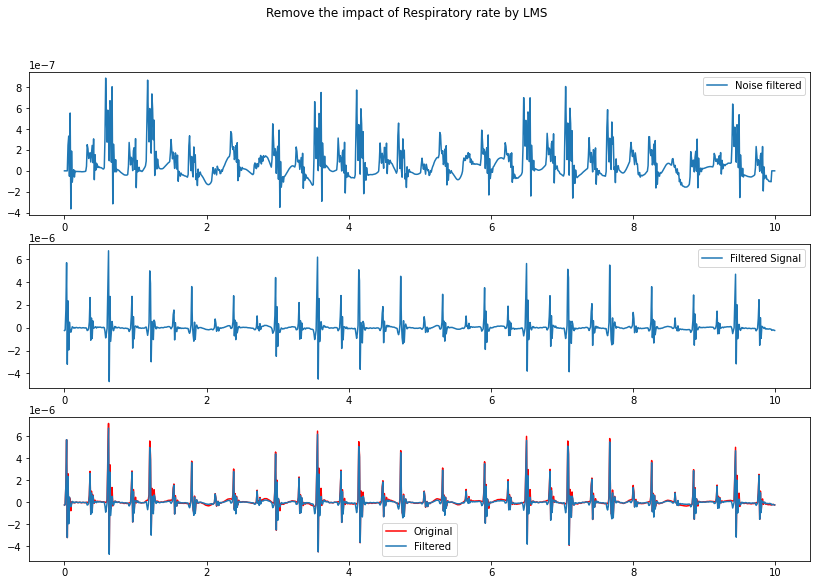

In [7]:
def LMS(input_signal, desired_signal, filter_order, learning_rate):
    """
    LMS adaptive filter implementation.

    Parameters:
        input_signal (numpy array): The input signal with noise.
        desired_signal (numpy array): The desired signal without noise.
        filter_order (int): The order of the adaptive filter.
        learning_rate (float): The step size for the adaptive algorithm.

    Returns:
        filtered_signal (numpy array): The filtered signal without noise.
        W (numpy array): The weight coefficients of the adaptive filter.
        error (numpy array): The error signal (difference between desired and filtered signal).
    """

    itr = len(input_signal)

    # initalize error and W
    error = np.random.uniform(0, 0.1, (itr, 1))
    W = np.random.uniform(0, 0.1, (filter_order, itr))
    
    # error and W can also be initalized like this
    # error = np.zeros((itr, 1))
    # W = np.zeros((filter_order, itr))

    for k in range(filter_order, itr):
        x = input_signal[k - filter_order: k]
        x_reversed = x[::-1]

        try:
            y = W[:, k - 2] @ x
        except:
            pass

        error[k-1] = desired_signal[k-1] - y
        W[:, k-1] = W[:, k - 2] + 2 * learning_rate * error[k-1] * x

    filtered_signal = np.ones(input_signal.shape) * np.nan # make plot easier 

    for k in range(filter_order, len(input_signal)):
        x = input_signal[k - filter_order: k]
        x_reversed = x[::-1]
        filtered_signal[k] = W[:, -2] @ x_reversed

    return filtered_signal, W, error


M, i  = 10, np.random.randint(1)

xn = signals_given[i]
dn = signals_given[i] 

mu = 0.1 

yn, W, en = LMS(xn, dn, M, mu)
yn_new = np.pad(yn[M:], (M//2, M - M//2),  mode='constant', constant_values=0)
t = np.linspace(0, 10, 10 * sampling_rate, endpoint=False)

fig, ax = plt.subplots(3, 1, figsize=(14, 9))


ax[0].plot(t, yn_new, label='Noise filtered')

ax[1].plot(t, xn - yn_new, label='Filtered Signal')


ax[2].plot(t, xn, 'r', label='Original' )
ax[2].plot(t, xn - yn_new , label='Filtered')


ax[0].legend()
ax[1].legend()
ax[2].legend()

fig.suptitle('Remove the impact of Respiratory rate by LMS')
fig.savefig('../Pic/Remove_RR_LMS.jpg', dpi=300)

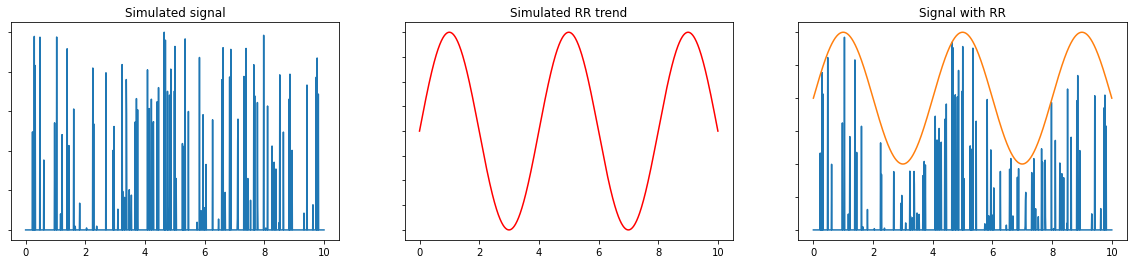

In [8]:
# Simluate the impact of RR

duration = 10
sampling_rate = 100
respiratory_rate = 15
num_points = duration * sampling_rate
x_space = np.linspace(0,1,num_points)
seg_fre = respiratory_rate / (60/duration)
# seg_amp = max(scg) * 0.00001
seg_amp = 1 * 0.00001
rr_component = seg_amp * np.sin(2 * np.pi * seg_fre * x_space)

scg = np.random.uniform(0, 1, num_points)


num_elements_to_one = int(0.66 * num_points)
random_array = np.random.rand(*scg.shape)
threshold = np.percentile(random_array, 90)
scg[random_array < threshold] = 0


fig, ax = plt.subplots(1, 3, figsize=(20, 4))
ax[0].plot(x_space * 10, scg)
ax[0].set_title('Simulated signal')
ax[0].set_yticklabels([])

scg *= (rr_component + 2 * seg_amp)
ax[1].plot(x_space * 10, rr_component + seg_amp * 2, 'r')
ax[1].set_title('Simulated RR trend')
ax[1].set_yticklabels([])
ax[2].plot(x_space * 10, scg)
ax[2].plot(x_space * 10, rr_component + seg_amp * 2)
ax[2].set_title('Signal with RR')
ax[2].set_yticklabels([])

fig.savefig('../Pic/RR_simultaion.jpg', dpi=300)

#### Step 2. Peaks Detection：Find max value in a sliding window


The peak detection algorithm previously used required prior knowledge of the Heartbeat Rate and also exhibited certain instances of missed peaks.

Based on a research paper on ECG peak localization, this is a simplified version.

Reference：
An Open-Source Feature Extraction Tool for the Analysis of Peripheral Physiological Data.

PaperLink: https://pubmed.ncbi.nlm.nih.gov/30443441/

In [9]:
def get_peaks(signal, hr, sampling_rate=100):
    """old algorithom"""

    window_size = int((60 *  sampling_rate) / hr) 
    peaks = np.zeros(len(signal))

    for i in range(0, len(signal)-window_size, window_size):
        # print(i, i+window_size)
        scg_window = signal[i:i+window_size]
        rpeak = np.argmax(scg_window)
        peaks[i+rpeak] = 1
        
    # Process the last portion of the signal    
    peaks[np.argmax(signal[i:])] = 1

    rpeaks = np.where(peaks == 1)[0]

    return rpeaks


def scg_findpeaks(signal, sampling_rate=100):
    """
    Find R-peaks in the SCG (Seismocardiogram) signal using a simple peak detection method.

    Parameters:
        signal (array_like): The SCG signal data.
        sampling_rate (int, optional): The sampling rate of the signal in Hz. Default is 100.

    Returns:
        rpeaks (array_like): An array containing the indices of R-peaks detected in the SCG signal.
    """
    # Define the window size
    # 400ms window -> Estimated Heartrate: 150 bpm
    window_size = int(0.4 * sampling_rate)

    # print(window_size)
    peaks = np.zeros(len(signal))

    for i in range(0, len(signal)- int(1.5 * window_size), int( window_size / 1.2)):
        scg_window = signal[i :i + int(1.5 * window_size)]
        rpeak = np.argmax(scg_window)
        # Update the peaks array with 1 at the location of the detected R-peak
        peaks[rpeak + i] = 1

    # Process the last portion of the signal
    scg_window = signal[i :]
    rpeak = np.argmax(scg_window)
    peaks[rpeak + i] = 1

    # Find the indices of R-peaks where peaks array equals 1
    rpeaks = np.where(peaks == 1)[0]

    return rpeaks

In [10]:
# Compare old algorithom with new algorithom
rpeaks_old = [get_peaks(signal, hr) for signal, hr in zip(signals_given, labels_given[:, 2])]
rpeaks_new = [scg_findpeaks(signal) for signal in signals_given]

#### Step 3. HR & RR Estimation


Create Envelope：

Don't know how to create envelope based on the parametric equations. 

I attemptted to extract the amplitude envelope of the signal from the original signal using Hilbert transform and then applyed a simple smoothing process resulted in poor performance.

HR Estimation：

1. The method, proposed by paper Helena, "empirical truncated statistics analysis" really works.
2. Peaks dection without knowing HR is hard.

RR Estimation：
1. Find large peaks and use these large peeks to do Interpolate. This method also works.

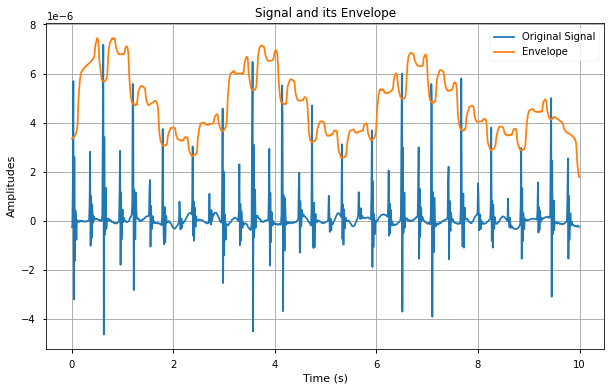

In [11]:
# Extract the amplitude envelope of the signal from the original signal using Hilbert transfor
# and apply a simple smoothing process. The result is not as expected, as shown in the following plot.

from scipy.signal import hilbert, convolve

fs = 100  # Sampling rate
t = np.linspace(0, 10, fs*10, endpoint=False)

signal = signals_given[0]

# Calculate the analytic signal
analytic_signal = hilbert(signal)

# Calculate the amplitude signal (envelope)
amplitude_envelope = np.abs(analytic_signal)
# amplitude_envelope = analytic_signal

# Smooth the signal
window = np.ones(100) / 15  # Moving average with a window size of 15
smoothed_envelope = convolve(amplitude_envelope, window, mode='same')

# plt.figure(facecolor='white')
plt.style.use('seaborn-notebook')
plt.figure(figsize=(10, 6))
plt.plot(t, signal, label='Original Signal')
plt.plot(t, smoothed_envelope, label='Envelope')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitudes')
plt.title('Signal and its Envelope')
plt.grid(True)

# plt.savefig('../Pic/Envelope_Hilbert.jpg', dpi=300)

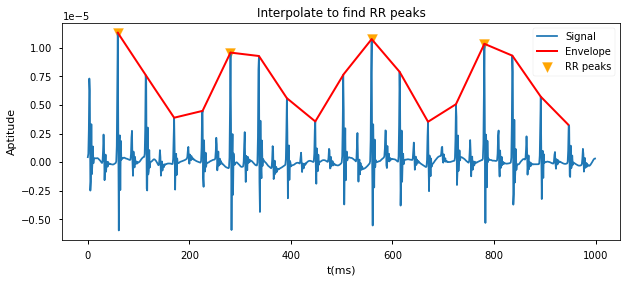

In [22]:
# interpolate

i = np.random.randint(2000)
# peaks_pos = rpeaks_old[i]
peaks_pos = rpeaks_new[i]

peaks_height = signals_given[i, peaks_pos]

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(signals_given[i], label='Signal')

kinds = ['linear', 'slinear', 'quadratic', 'cubic']
f = interpolate.interp1d(peaks_pos, peaks_height, kinds[1])

xnew = np.arange(peaks_pos[0], peaks_pos[-1], 1)
ynew = f(xnew) 
ax.plot(xnew, ynew, color='red', linewidth='2', label='Envelope')

x_padded = np.arange(0, 10, 1000)
y_padded = np.pad(ynew, (peaks_pos[0], 1000-peaks_pos[-1]),  mode='constant', constant_values=0)
peaks, _ = find_peaks(y_padded)  

ax.scatter(peaks, y_padded[peaks], color='orange', marker='v', s=100, label='RR peaks')
ax.set_xlabel('t(ms)')
ax.set_ylabel('Aptitude')
ax.set_title('Interpolate to find RR peaks')

ax.legend()

fig.savefig('../Pic/Interpolate_RR_'+str(i)+'.jpg',dpi=300)

In [24]:
def HR_estimation(peaks_pos, sampling_rate=100):
    """
    Estimate heart rate using Empirical Truncated Statistics Analysis method.

    Parameters:
        peaks_pos (array_like): A 1-dimensional array or list containing the positions of detected peaks in the signal.
        sampling_rate (int, optional): The sampling rate of the signal in Hz. Default is 100.

    Returns:
        hr_estimate_subset (int): Estimated heart rate (beats per minute) based on the subset of distances between consecutive peaks.
        hr_estimate_all (int): Estimated heart rate (beats per minute) based on all distances between consecutive peaks.
    """

    # Calculate the time intervals (distances) between consecutive peaks
    distance = np.diff(peaks_pos)

    # Sort the distance data
    sorted_distance = np.sort(distance)

    # Calculate the index range for the 10%-90% subset
    start_index = int(0.1 * len(sorted_distance))
    end_index = int(0.9 * len(sorted_distance))

    # Extract the 10%-90% subset of data
    subset_data = sorted_distance[start_index:end_index]

    # Calculate the average of the subset to estimate heart rate
    HR_dis = np.mean(subset_data)

    # Calculate heart rate estimates based on the average distance and all distances
    hr_estimate_subset = (60 * sampling_rate) // HR_dis
    hr_estimate_all = (60 * sampling_rate) // np.mean(distance)

    return hr_estimate_subset, hr_estimate_all

In [25]:
from scipy import interpolate

def RR_estimation(signal, peaks_pos, sampling_rate=100):
    """
    Estimate RR interval (RR_dis) and heart rate (beats per minute) from large peaks in the signal.

    Parameters:
        signal (array_like): The input signal from which peaks are detected.
        peaks_pos (array_like): A 1-dimensional array or list containing the positions of detected peaks in the signal.
        sampling_rate (int, optional): The sampling rate of the signal in Hz. Default is 100.

    Returns:
        hr_estimate (int): Estimated heart rate (beats per minute) based on the RR_dis.
    """

    # Get the heights of the peaks from the signal
    peaks_height = signal[peaks_pos]

    # Interpolate the peak heights to get a smoother representation of the signal, and use linear interpolation 
    kinds = ['linear', 'slinear', 'quadratic', 'cubic']
    f = interpolate.interp1d(peaks_pos, peaks_height, kinds[0])

    # Generate a new array of positions for interpolated values
    xnew = np.arange(peaks_pos[0], peaks_pos[-1], 1)
    ynew = f(xnew)   # Use interpolation function returned by `interp1d`

    # Pad the interpolated values to match the original signal length
    # x_padded = np.arange(0, len(signal))
    y_padded = np.pad(ynew, (peaks_pos[0], 1000 - peaks_pos[-1]), mode='constant', constant_values=0)

    # Find the peaks in the padded interpolated signal
    rr_peaks, _ = find_peaks(y_padded)

    # plt.scatter(rr_peaks, y_padded[rr_peaks], marker='x')
    # plt.plot(x_padded, signal)
    
    # Calculate the RR interval (RR_dis) as the maximum difference between consecutive RR peaks
    RR_dis = np.max(np.diff(rr_peaks))

    # Calculate the estimated heart rate (HR) in beats per minute (bpm)
    hr_estimate = (60 * sampling_rate) // RR_dis

    return hr_estimate

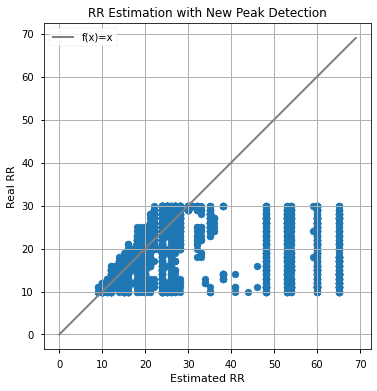

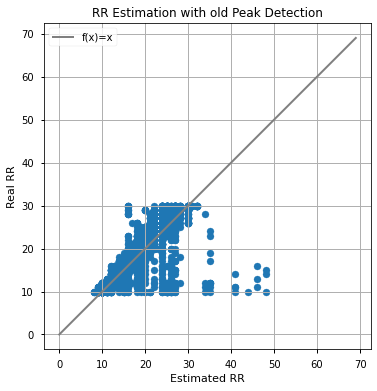

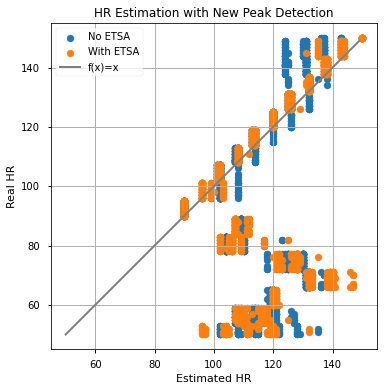

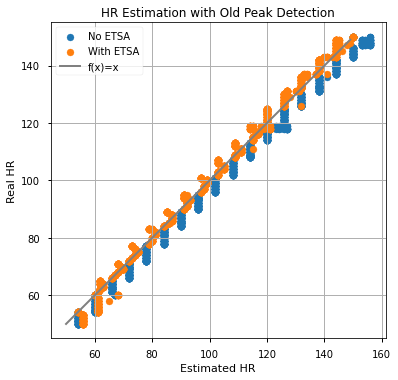

In [85]:
# labels = labels_given[n, 3]
def plot_RR_estimation(signals, rpeaks, labels, string, N=3000, path='../Pic/'):
    xs, ys = [], []
    for n in range(N):
        x, y = RR_estimation(signals[n], rpeaks[n]), labels[n]
        xs.append(x)
        ys.append(y)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(xs, ys)
    
    ax.plot(np.arange(0, 70, 1), np.arange(0, 70, 1),color='gray',linewidth=2, label='f(x)=x')
    ax.set_title('RR Estimation ' + string)
    ax.set_aspect('equal')
    ax.set_xlabel('Estimated RR')
    ax.set_ylabel('Real RR')
    ax.grid(True)
    ax.legend()
    fig.savefig(path + 'RR Estimation ' + string + '.jpg', dpi=300)

plot_RR_estimation(signals=signals_given, rpeaks=rpeaks_new, labels=labels_given[:, 3], string='with New Peak Detection')
plot_RR_estimation(signals=signals_given, rpeaks=rpeaks_old, labels=labels_given[:, 3], string='with old Peak Detection')


In [ ]:

def plot_HR_estimation(rpeaks, labels, string, N=3000, path='../Pic/'):

    xs, ys, xopts = [], [], []

    for n in range(N):
        (x_opt,x), y = HR_estimation(rpeaks[n]), labels[n]
        xs.append(x)
        ys.append(y)
        xopts.append(x_opt)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(xs,ys,label='No ETSA')
    ax.scatter(xopts,ys,label='With ETSA')

    ax.plot(np.arange(50, 150, 1), np.arange(50, 150, 1),color='gray',linewidth=2, label='f(x)=x')
    ax.set_title('HR Estimation ' + string)
    ax.set_aspect('equal')
    ax.set_xlabel('Estimated HR')
    ax.set_ylabel('Real HR')
    ax.grid(True)
    ax.legend()
    fig.savefig(path + 'RR Estimation ' + string + '.jpg', dpi=300)

plot_HR_estimation(rpeaks=rpeaks_new, labels=labels_given[:, 2], string='with New Peak Detection')
plot_HR_estimation(rpeaks=rpeaks_old, labels=labels_given[:, 2], string='with Old Peak Detection')

#### Step 4. Slice and Stack

Usually, before denoising, people will check the signals' quality and fix bad quality signals. I didn'd do that. By being stacked using clustering, low quality sliced pieces will be filtered.

I sliced signals by margin I mentioned last week and ake a comparison bewteen different stack method:
* K-means Clustering
* Hierarchical Clustering
* Mean / Median

K-means Clusteringsometimes will cause problems. Hierarchical Clustering have fewer parameters and is easier.

Inspired by paper "Novel Signal Noise Reduction Method through Cluster Analysis, Applied to Photoplethysmography"

##### K-means Clustering

In [112]:
from sklearn.cluster import KMeans

def kmeans_clustering_with_stop(signals, threshold, N):
    n_clusters = N  # 3 clusters
    kmeans = KMeans(n_clusters=n_clusters)

    # Step 2: Perform clustering
    cluster_labels = kmeans.fit_predict(signals)

    # Count the number of signals in each cluster
    cluster_counts = np.bincount(cluster_labels)

    # Check if any cluster has more than N * threshold signals
    if any(cluster_counts > N * threshold):
        # Stop clustering and find the median of the dominant cluster
        dominant_cluster_idx = np.argmax(cluster_counts)
        dominant_cluster_signals = signals[cluster_labels == dominant_cluster_idx]
        median_signal = np.median(dominant_cluster_signals, axis=0)
        return median_signal
    else:
        # Continue clustering
        # print('K-means Clustering Continues')
        return kmeans_clustering_with_stop(signals, threshold, N-1)

##### Hierarchical Clustering

In [87]:
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist

def hierarchical_clustering_with_stop(signals, threshold, N):
    # Step 2: Perform hierarchical clustering
    linkage_matrix = linkage(pdist(signals, metric='euclidean'), method='ward')

    # Step 3: Assign signals to clusters based on distance and N * threshold
    cluster_labels = fcluster(linkage_matrix, t=N * threshold, criterion='distance')

    # Step 4: Count the number of signals in each cluster
    cluster_counts = np.bincount(cluster_labels)

    # Step 5: Check if any cluster has more than N * threshold signals
    if any(cluster_counts > N * threshold):
        # Stop clustering and find the median of the dominant cluster
        dominant_cluster_idx = np.argmax(cluster_counts)
        dominant_cluster_signals = signals[cluster_labels == dominant_cluster_idx]
        median_signal = np.median(dominant_cluster_signals, axis=0)
        return median_signal
    else:
        # Continue clustering
        print('Hierarchical Clustering Continues')
        return hierarchical_clustering_with_stop(signals,threshold, N)

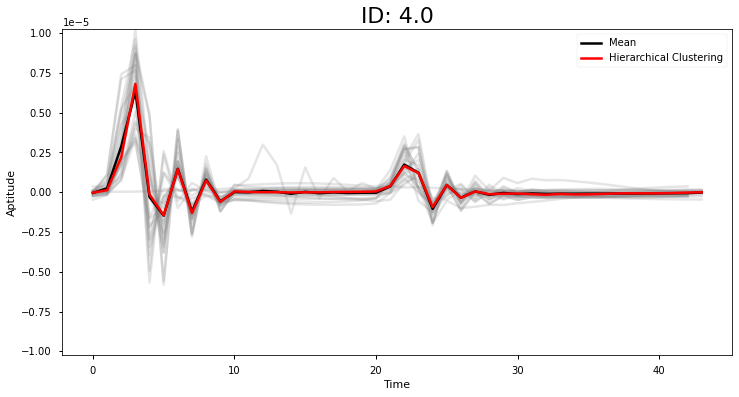

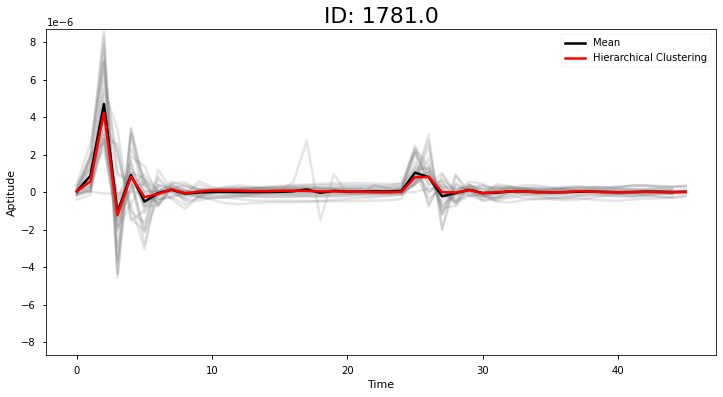

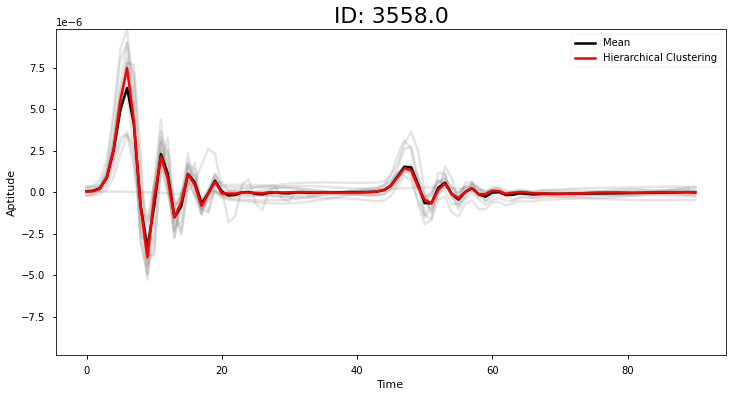

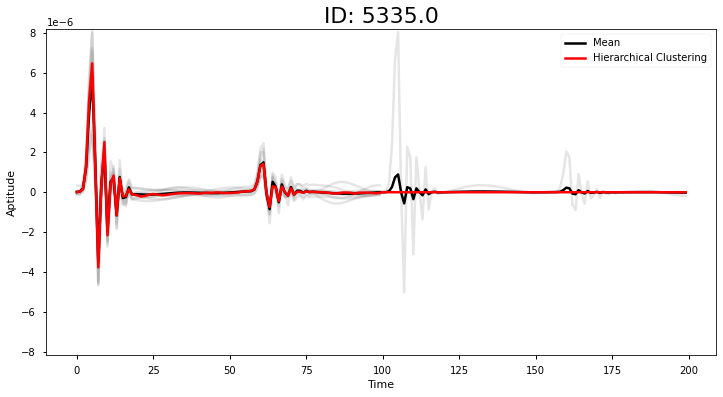

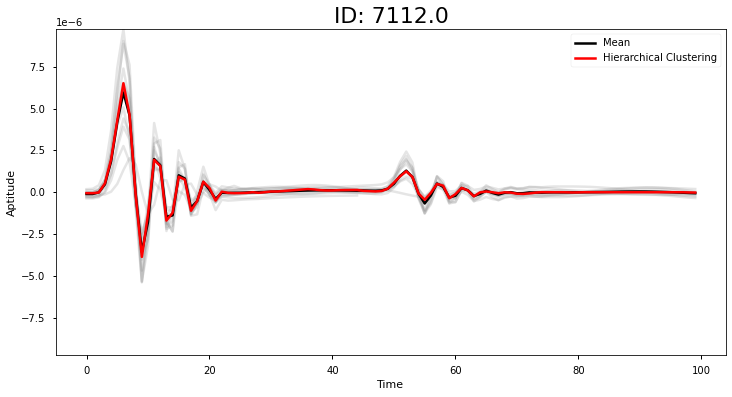

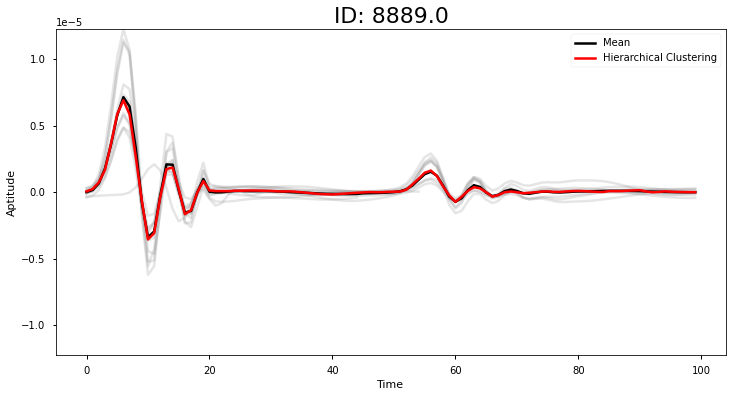

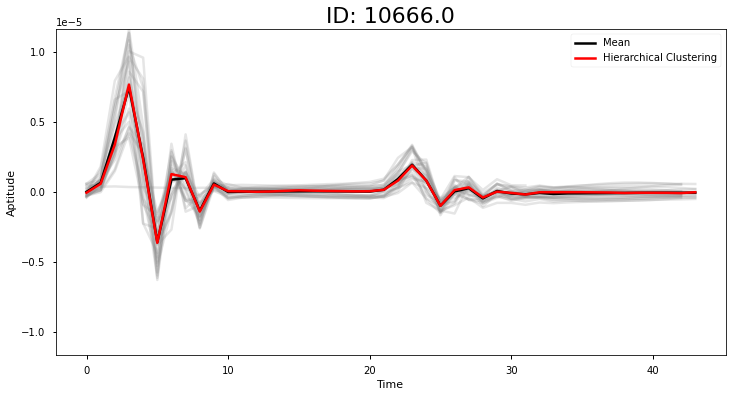

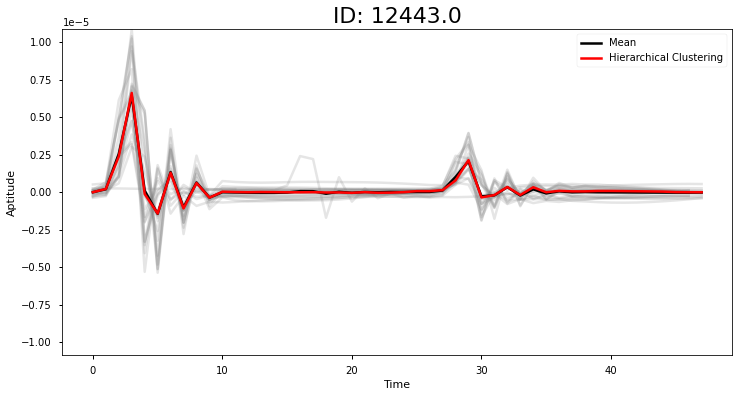

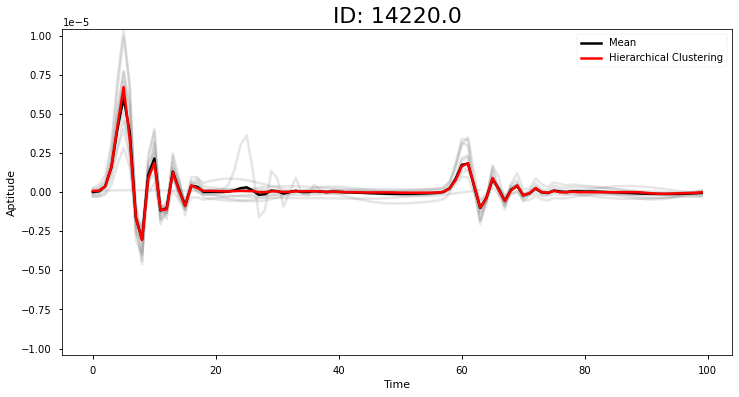

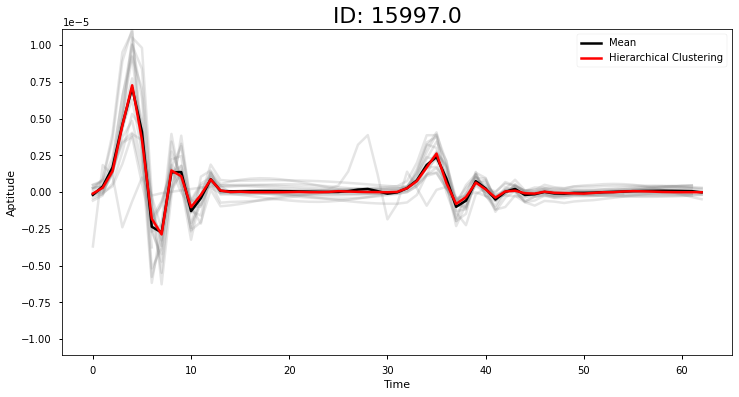

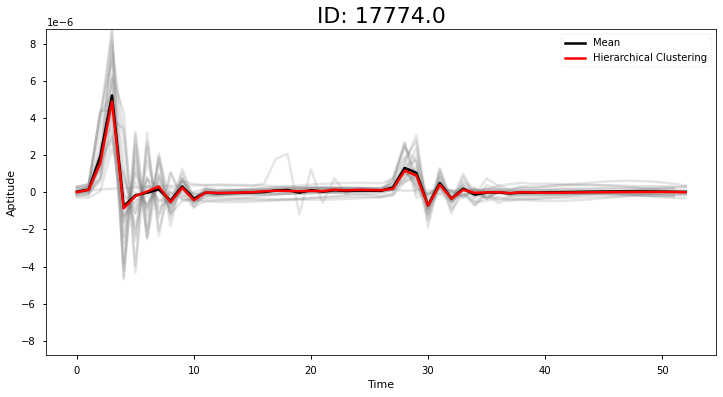

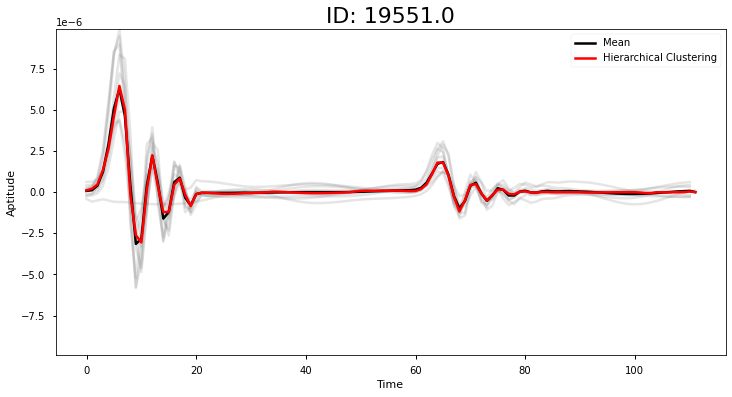

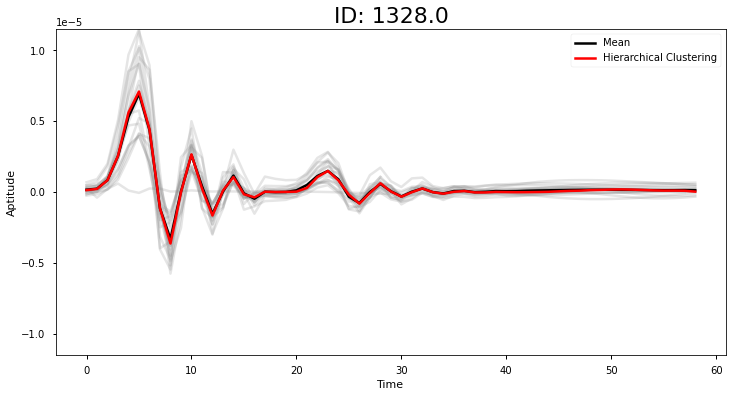

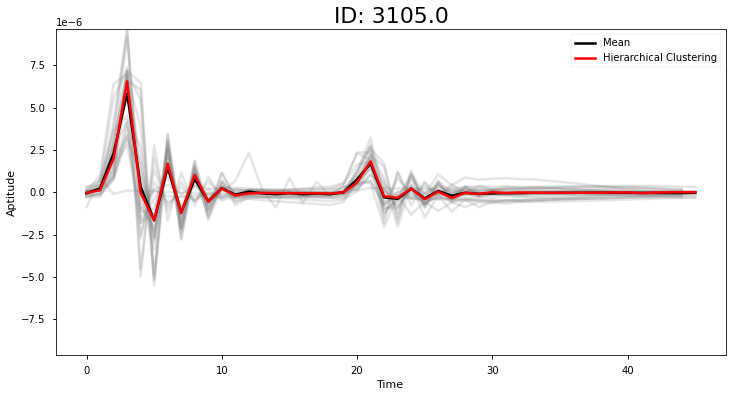

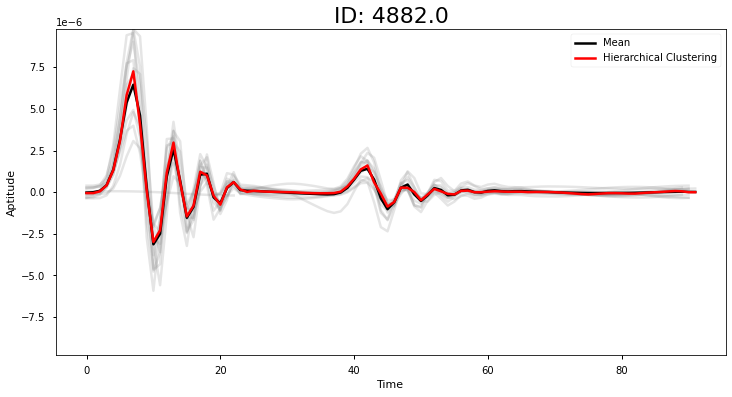

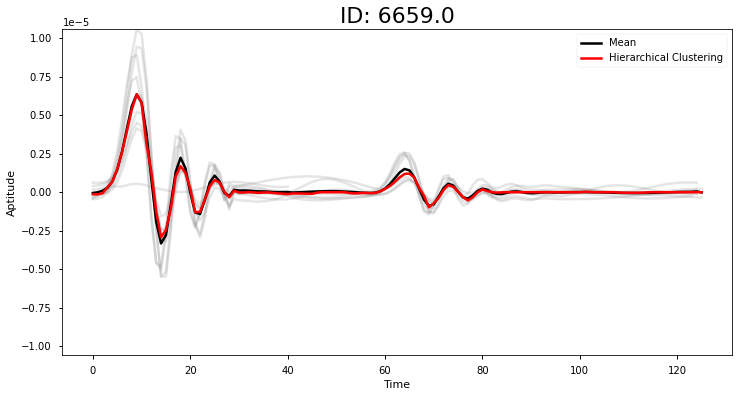

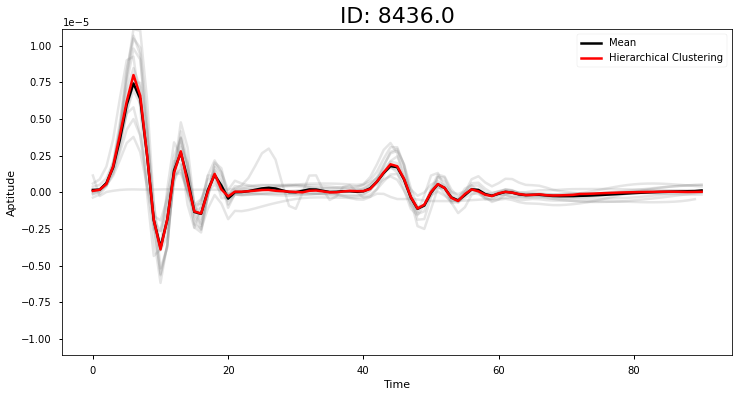

In [126]:
def slice(signals, rpeaks, ids, time):
    
    for cnt, (signal, rpeak, ID) in enumerate(zip(signals, rpeaks, ids)):
        # if cnt % 1777 != 4:
        # # if cnt % 1331 != 31:
        #     continue

        fig, ax = plt.subplots(figsize=(12, 6))

        ymax = max(signal)

        begin, end = 0, 0
        margin = rpeak[0]
        pieces = []
        for num in range(1, len(rpeak)):
            begin = end
            end = rpeak[num] - margin
            pieces.append(signal[begin: end])
        pieces.append(signal[end: 1000])

        Nmax = 0
        for piece in pieces:
            Nmax = max(Nmax, piece.shape[0])
            ax.plot(piece, alpha = 0.2, color='gray', linewidth=2.5 )

        pieces_padded = []
        for piece in pieces:
            N = Nmax - piece.shape[0]
            pieces_padded.append(np.pad(piece, (0, N), 'constant'))

        pieces_padded = np.array(pieces_padded)
        threshold = 0.8

        res = hierarchical_clustering_with_stop(pieces_padded, threshold, pieces_padded.shape[0])
        res_2 = kmeans_clustering_with_stop(pieces_padded, threshold, pieces_padded.shape[0])

        ax.plot(pieces_padded.mean(0), label='Mean',color='black', linewidth=2.5)
        # ax.plot(np.median(pieces_padded, 0), label='median',color='black', linewidth=2.5)
        # ax.plot(res_2, label='K-means Clustering',color='blue', linewidth=2.5)
        ax.plot(res, label='Hierarchical Clustering',color='red', linewidth=2.5)

        ax.set_xlabel("Time")
        ax.set_ylabel("Aptitude")
        ax.set_ylim(ymax * -1, ymax)
        ax.set_title('ID: ' + str(ID), fontsize=22)
        plt.legend()

        # plt.savefig('../Pic/ID'+str(ID)+'_'+ str(time) +'.jpg', dpi = 300)

        # if cnt > 30000:
        #     break

        return pieces_padded

pieces = slice(signals_given, rpeaks_old, labels_given[:, 1], 0)

In [ ]:
# Mian function and all code
if __name__ == '__main__':
    # load_data
    data = np.load('../Data/simu_1000_6.npy')

    signal_data, labels_data = data[:, :-6], data[:, -6:]
    data.shape, signal_data.shape, labels_data.shape

    sampling_rate = 100  # Hz
    duration = 10

    data_train = np.load('../Data/simu_20000_0.1_90_140_train.npy')
    data_test = np.load('../Data/simu_10000_0.1_141_178_test.npy')

    test_exemple = 10000

    data = np.concatenate((data_train, data_test), 0)
    labels_given, signals_given =  data[:, -6:], data[:, :1000]

    # Add noise
    noisy_signals = np.zeros_like(signal_data)
    # print(noisy_signals.shape)

    for i, signal in enumerate(signal_data):
        noisy_signals[i, :] = add_awgn(signal, 5)


    clean_signals = filter_noise(noisy_signals, 100)
    calculate_snr(signal_data, clean_signals-signal_data).mean()

    # Compare old algorithom with new algorithom
    rpeaks_old = [get_peaks(signal, hr) for signal, hr in zip(signals_given, labels_given[:, 2])]
    rpeaks_new = [scg_findpeaks(signal) for signal in signals_given]

    plot_RR_estimation(signals=signals_given, rpeaks=rpeaks_new, labels=labels_given[:, 3], string='with New Peak Detection')
    plot_RR_estimation(signals=signals_given, rpeaks=rpeaks_old, labels=labels_given[:, 3], string='with old Peak Detection')

    plot_HR_estimation(rpeaks=rpeaks_new, labels=labels_given[:, 2], string='with New Peak Detection')
    plot_HR_estimation(rpeaks=rpeaks_old, labels=labels_given[:, 2], string='with Old Peak Detection')

    
    pieces = slice(signals_given, rpeaks_old, labels_given[:, 1], 0)